In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns   # optional but useful for confusion matrix (install if you want)

In [3]:
# -----------------------------
# 1. Reproducibility
# -----------------------------
RND = 42
random.seed(RND)
np.random.seed(RND)


In [4]:
# 2. Algorithm simulators
# -----------------------------
def fifo(pages, frames):
    memory, faults = [], 0
    for page in pages:
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                memory.pop(0)
                memory.append(page)
    return faults

def lru(pages, frames):
    memory, faults = [], 0
    for i, page in enumerate(pages):
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                # Find least recently used in memory
                last_indexes = []
                for p in memory:
                    rev = pages[:i][::-1]
                    if p in rev:
                        last_indexes.append(rev.index(p))
                    else:
                        last_indexes.append(float('inf'))
                lru_idx = int(np.argmax(last_indexes))
                memory[lru_idx] = page
    return faults

def optimal(pages, frames):
    memory, faults = [], 0
    for i, page in enumerate(pages):
        if page not in memory:
            faults += 1
            if len(memory) < frames:
                memory.append(page)
            else:
                future = pages[i+1:]
                farthest_index = -1
                page_to_remove = None
                for p in memory:
                    if p in future:
                        index = future.index(p)
                    else:
                        index = float('inf')
                    if index > farthest_index:
                        farthest_index = index
                        page_to_remove = p
                memory.remove(page_to_remove)
                memory.append(page)
    return faults


In [5]:
# 3. Sequence generator (with small improvements)
# -----------------------------
def generate_sequence(n_pages, length, locality):
    seq = []
    for _ in range(length):
        if random.random() < locality and seq:
            # pick recent item to model locality
            seq.append(random.choice(seq[-max(1, min(5, len(seq))):]))
        else:
            seq.append(random.randint(0, n_pages - 1))
    return seq


In [6]:
# 4. Balanced dataset generation with extra features
# -----------------------------
def create_balanced_dataset(target_each=300):  # 300*3 = 900 samples
    data = []
    counts = {"FIFO":0, "LRU":0, "Optimal":0}
    attempts = 0
    while min(counts.values()) < target_each and attempts < 20000:
        attempts += 1
        n_pages = random.randint(5, 40)
        frames = random.randint(1, min(12, max(1, n_pages//1)))  # frames <= pages reasonably
        seq_len = random.randint(20, 200)
        locality = round(random.uniform(0.05, 0.95), 2)
        seq = generate_sequence(n_pages, seq_len, locality)

        f = fifo(seq, frames)
        l = lru(seq, frames)
        o = optimal(seq, frames)
        best = min([("FIFO", f), ("LRU", l), ("Optimal", o)], key=lambda x: x[1])[0]

        if counts[best] < target_each:
            # extra features
            frames_to_pages = frames / max(1, n_pages)
            avg_faults = np.mean([f, l, o])
            # frequency variance of pages (gives idea of repetition)
            vals, cnts = np.unique(seq, return_counts=True)
            freq_var = np.var(cnts) if len(cnts)>0 else 0.0

            data.append([n_pages, frames, locality, seq_len, frames_to_pages, freq_var, f, l, o, best])
            counts[best] += 1

    df = pd.DataFrame(data, columns=[
        "num_pages","memory_size","locality","sequence_len",
        "frames_to_pages","freq_var","fifo_faults","lru_faults","optimal_faults","best_algo"
    ])
    return df, counts

df, counts = create_balanced_dataset(target_each=250)  # adjust number for runtime
print("Class counts:", counts)
print(df["best_algo"].value_counts())

Class counts: {'FIFO': 250, 'LRU': 250, 'Optimal': 250}
best_algo
FIFO       250
Optimal    250
LRU        250
Name: count, dtype: int64


In [7]:
# Save dataset
df.to_csv("improved_page_replacement_dataset.csv", index=False)
print("Saved: improved_page_replacement_dataset.csv")

Saved: improved_page_replacement_dataset.csv


In [8]:
# 5. Features / labels and train/test split
# -----------------------------
features = ["num_pages","memory_size","locality","sequence_len","frames_to_pages","freq_var"]
X = df[features]
y = df["best_algo"]

le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RND, stratify=y_enc)

# Optional scaling for models like LogisticRegression / SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=RND),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RND),
    "SVM": SVC(kernel="rbf", probability=True, random_state=RND)
}

results = {}
for name, model in models.items():
    if name == "LogisticRegression" or name=="SVM":
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = (model, acc)
    print(f"{name} accuracy: {acc:.3f}")
    print(classification_report(y_test, preds, target_names=le.classes_))
    print("-"*40)

# Choose best model by accuracy
best_name = max(results, key=lambda k: results[k][1])
best_model = results[best_name][0]
print("Best model:", best_name, "with accuracy", results[best_name][1])

# If best model needs scaler, we save scaler too
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(best_model, "best_algo_model.pkl")
print("Saved models: label_encoder.pkl, scaler.pkl, best_algo_model.pkl")

RandomForest accuracy: 0.820
              precision    recall  f1-score   support

        FIFO       0.85      0.80      0.82        50
         LRU       0.73      0.80      0.76        50
     Optimal       0.90      0.86      0.88        50

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150

----------------------------------------
LogisticRegression accuracy: 0.540
              precision    recall  f1-score   support

        FIFO       0.35      0.26      0.30        50
         LRU       0.51      0.62      0.56        50
     Optimal       0.71      0.74      0.73        50

    accuracy                           0.54       150
   macro avg       0.52      0.54      0.53       150
weighted avg       0.52      0.54      0.53       150

----------------------------------------
SVM accuracy: 0.740
              precision    recall  f1-score   support

        FIFO     

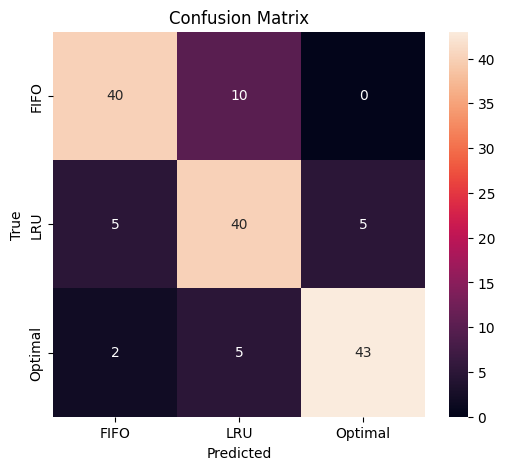

In [10]:
# 7. Confusion matrix visualization
# -----------------------------
if best_name == "LogisticRegression" or best_name == "SVM":
    y_pred = best_model.predict(X_test_scaled)
else:
    y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

In [11]:
# 8. Quick test predictions (use DataFrame with feature names to avoid warnings)
# -----------------------------
def predict_sample(sample, use_scaled=False):
    # sample: [num_pages, memory_size, locality, sequence_len]
    frames_to_pages = sample[1] / max(1, sample[0])
    # create dummy sequence to compute freq_var? We don't have seq here -
    # we'll set freq_var = small value for demo (or you can compute from an actual sequence)
    freq_var = 0.0
    row = pd.DataFrame([[sample[0], sample[1], sample[2], sample[3], frames_to_pages, freq_var]],
                       columns=features)
    if use_scaled:
        arr = scaler.transform(row)
        pred = best_model.predict(arr)
    else:
        pred = best_model.predict(row)
    return le.inverse_transform(pred)[0]

print("Example predictions:")
print([5,2,0.1,30], "->", predict_sample([5,2,0.1,30], use_scaled=(best_name!="RandomForest")))
print([30,8,0.8,150], "->", predict_sample([30,8,0.8,150], use_scaled=(best_name!="RandomForest")))

Example predictions:
[5, 2, 0.1, 30] -> Optimal
[30, 8, 0.8, 150] -> Optimal


In [12]:
import joblib, pandas as pd

best_model = joblib.load("best_algo_model.pkl")
le = joblib.load("label_encoder.pkl")
scaler = joblib.load("scaler.pkl")   # needed for some models

features = ["num_pages","memory_size","locality","sequence_len","frames_to_pages","freq_var"]
def model_predict(num_pages_val, memory_size_val, locality_val, sequence_len_val):
    frames_to_pages = memory_size_val / max(1, num_pages_val)
    freq_var = 0.0  # or compute if you provide sequence
    df_input = pd.DataFrame([[num_pages_val, memory_size_val, locality_val, sequence_len_val, frames_to_pages, freq_var]],
                            columns=features)
    # if using scaled model:
    try:
        arr = scaler.transform(df_input)
        pred = best_model.predict(arr)
    except:
        pred = best_model.predict(df_input)
    return le.inverse_transform(pred)[0]


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
import joblib

# --- Load saved model, encoder, and scaler (if needed) ---
model = joblib.load("best_algo_model.pkl")
le = joblib.load("label_encoder.pkl")
try:
    scaler = joblib.load("scaler.pkl")
    use_scaled = True
except:
    scaler = None
    use_scaled = False

# Features for prediction
features = ["num_pages","memory_size","locality","sequence_len","frames_to_pages","freq_var"]

# --- Create input widgets ---
num_pages = widgets.IntSlider(value=10, min=5, max=50, step=1, description="No. of Pages:")
memory_size = widgets.IntSlider(value=3, min=2, max=12, step=1, description="Frames:")
locality = widgets.FloatSlider(value=0.5, min=0.05, max=0.95, step=0.05, description="Locality:")
sequence_len = widgets.IntSlider(value=50, min=10, max=200, step=10, description="Seq Length:")

# Output area
out = widgets.Output()

# --- Prediction function ---
def predict_algo(change):
    with out:
        clear_output()
        frames_to_pages = memory_size.value / max(1, num_pages.value)
        freq_var = 0.0  # placeholder; optional if you have sequence info
        df_input = pd.DataFrame([[num_pages.value, memory_size.value, locality.value, sequence_len.value,
                                  frames_to_pages, freq_var]],
                                columns=features)
        
        # Scale if needed
        if use_scaled:
            df_input_scaled = scaler.transform(df_input)
            pred = model.predict(df_input_scaled)
        else:
            pred = model.predict(df_input)
        
        pred_algo = le.inverse_transform(pred)[0]
        print(f"🧠 Predicted Best Algorithm: {pred_algo}")

# --- Button to trigger prediction ---
button = widgets.Button(description="Predict Best Algorithm", button_style='success')
button.on_click(predict_algo)

# --- Display sliders and button ---
display(num_pages, memory_size, locality, sequence_len, button, out)


IntSlider(value=10, description='No. of Pages:', max=50, min=5)

IntSlider(value=3, description='Frames:', max=12, min=2)

FloatSlider(value=0.5, description='Locality:', max=0.95, min=0.05, step=0.05)

IntSlider(value=50, description='Seq Length:', max=200, min=10, step=10)

Button(button_style='success', description='Predict Best Algorithm', style=ButtonStyle())

Output()